In [1]:
#%matplotlib notebook
%matplotlib inline

import os.path
import numpy as np
import scipy.linalg as la
from numpy import *
from os import path
home = path.expanduser("~")

from matplotlib import animation
import matplotlib.pyplot as plt

# define format for the plots
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [6., 4.5]
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.labelsize'] = 15
mpl.rcParams['xtick.major.width'] = 1.0
mpl.rcParams['xtick.minor.width'] = 0.8
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['xtick.direction'] = "in"
mpl.rcParams['ytick.right'] = True
mpl.rcParams['ytick.labelsize'] = 15
mpl.rcParams['ytick.major.width'] = 1.0
mpl.rcParams['ytick.minor.width'] = 0.8
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['ytick.direction'] = "in"
mpl.rcParams['legend.fontsize'] = 15
mpl.rcParams['legend.numpoints'] = 1
mpl.rcParams['font.size'] = 15
mpl.rcParams['savefig.format'] = "pdf"

working_path = "/Users/iamatreeinfall/Desktop/Causality"

In [2]:
# define the contour levels
levels = linspace(0.13, 0.45, 50)

# define a custmized color map
colors1 = array([[1, 1, 1, 1]])
colors2 = plt.cm.jet(linspace(0., 1, 10))
colors = vstack((colors1, colors2))
my_cmap = mpl.colors.LinearSegmentedColormap.from_list('my_colormap', colors)

In [3]:
def get_medium_at_tau(itau_, data_):
    ed = zeros([neta, nx, ny])
    T  = zeros([neta, nx, ny])
    cs2 = zeros([neta, nx, ny])
    vx = zeros([neta, nx, ny])
    vy = zeros([neta, nx, ny])
    pixx = zeros([neta, nx, ny])
    pixy = zeros([neta, nx, ny])
    pixz = zeros([neta, nx, ny])
    piyy = zeros([neta, nx, ny])
    piyz = zeros([neta, nx, ny])
    bulkpi = zeros([neta, nx, ny])
    
    idx = (abs(data_[:, 0] - itau_) < 0.1)
    data_cut = data_[idx, :]
    for igrid in range(len(data_cut[:, 0])):
        x_idx   = int(data_cut[igrid, 1] + 0.1)
        y_idx   = int(data_cut[igrid, 2] + 0.1)
        eta_idx = int(data_cut[igrid, 3] + 0.1)
        u0 = sqrt(1. + data_cut[igrid, 8]**2.
                  + data_cut[igrid, 9]**2. + data_cut[igrid, 10]**2)
        ed[eta_idx, x_idx, y_idx] = data_cut[igrid, 4]
        T[eta_idx, x_idx, y_idx]  = data_cut[igrid, 6]
        cs2[eta_idx, x_idx, y_idx] = data_cut[igrid, 7]
        vx[eta_idx, x_idx, y_idx] = data_cut[igrid, 8]/u0
        vy[eta_idx, x_idx, y_idx] = data_cut[igrid, 9]/u0
        pixx[eta_idx, x_idx, y_idx] = data_cut[igrid, 11]
        pixy[eta_idx, x_idx, y_idx] = data_cut[igrid, 12]
        pixz[eta_idx, x_idx, y_idx] = data_cut[igrid, 13]
        piyy[eta_idx, x_idx, y_idx] = data_cut[igrid, 14]
        piyz[eta_idx, x_idx, y_idx] = data_cut[igrid, 15]
        bulkpi[eta_idx, x_idx, y_idx] = data_cut[igrid, 16]
    return(ed, T, vx, vy, cs2, pixx, pixy, pixz, piyy, piyz, bulkpi)

def get_eigenvalue(xx,xy,xz,yy,yz):
    zz = - xx - yy
    neta, nx, ny = xx.shape
    Lambda_1 = zeros([neta, nx, ny])
    Lambda_2 = zeros([neta, nx, ny])
    Lambda_3 = zeros([neta, nx, ny])
    for i in range(neta):
        for j in range(nx):
            for k in range(ny):
                pi_tensor = np.array([[xx[i,j,k], xy[i,j,k], xz[i,j,k]],
                                      [xy[i,j,k], yy[i,j,k], yz[i,j,k]],
                                      [xz[i,j,k], yz[i,j,k], zz[i,j,k]]])
                w,v = la.eig(pi_tensor)
                w = np.sort(w)
                Lambda_1[i,j,k] = float(w[0])
                Lambda_2[i,j,k] = float(w[1])
                Lambda_3[i,j,k] = float(w[2])
    return Lambda_1, Lambda_2, Lambda_3

def get_eigenvalue_list(xx, xy, xz, yy, yz):
    zz = - xx - yy
    ncells = len(xx)
    Lambda_1 = zeros(ncells)
    Lambda_2 = zeros(ncells)
    Lambda_3 = zeros(ncells)
    for i in range(ncells):
        pi_tensor = np.array([[xx[i], xy[i], xz[i]],
                              [xy[i], yy[i], yz[i]],
                              [xz[i], yz[i], zz[i]]])
        w,v = la.eig(pi_tensor)
        w = np.sort(w)
        Lambda_1[i] = float(w[0])
        Lambda_2[i] = float(w[1])
        Lambda_3[i] = float(w[2])
    return Lambda_1, Lambda_2, Lambda_3

# change the following line to your results folder

In [4]:
# change the following line to your results folder
ResultFolder = "hydro_evo"
#ResultFolder = "pAuC0-5"

In [5]:
# load hydrodynamic evolution data
data = fromfile(path.join(working_path, ResultFolder, "MUSIC",
                          "evolution_all_xyeta.dat"), dtype=float32)
# read header about the grid information
header = data[0:16]

# read in data and reshape it to the correct form
data = data[16:].reshape(-1, int(header[-1]))

# get the list for tau frame
tau_list = unique(data[:, 0])
ntau = len(tau_list)
tau0= header[0]; dtau = header[1];
tau_list = array([tau0 + i*dtau for i in range(ntau)])

# define 3D grid in x, y, and eta_s (space-time rapidity)
neta = int(header[8])
eta_size = -2.*header[10]
deta = header[9]
eta = array([-eta_size/2.+i*deta for i in range(neta)])

nx = int(header[2])
x_size = 2.*abs(header[4])
dx = header[3]
x = array([-x_size/2.+i*dx for i in range(nx)])

ny = int(header[5])
y_size = 2.*abs(header[7])
dy = header[6]
y = array([-y_size/2.+i*dy for i in range(ny)])

# print out some useful information about the evolution file
print("Read in data completed.")
print("ntau = {0}, tau_min = {1:.2f} fm, tau_max = {2:.2f} fm, dtau = {3:.3f} fm".format(
                            ntau, tau_list[0], tau_list[-1], dtau))
print("nx = {0}, x_min = {1:.2f} fm, x_max = {2:.2f} fm, dx = {3:.2f} fm".format(
                            nx, x[0], x[-1], dx))
print("ny = {0}, y_min = {1:.2f} fm, y_max = {2:.2f} fm, dy = {3:.2f} fm".format(
                            ny, y[0], y[-1], dy))
print("neta = {0}, eta_min = {1:.2f} fm, eta_max = {2:.2f} fm, deta = {3:.2f}".format(
                            neta, eta[0], eta[-1], deta))

FileNotFoundError: [Errno 2] No such file or directory: '/Users/iamatreeinfall/Desktop/Causality/hydro_evo/MUSIC/evolution_all_xyeta.dat'

## make a 2D contour plot for initial temperature distribution in the transverse plane

In [6]:
# make a 2D meshgrid in the transverse plane
X, Y = meshgrid(x, y)

data_tauframe = get_medium_at_tau(0, data)

# make the contour plot
fig = plt.figure()
cont = plt.contourf(X, Y, data_tauframe[1][0, :, :].transpose(),
                    levels, cmap=my_cmap, extend='both')
cbar = fig.colorbar(cont)
plt.xlabel(r"$x$ (fm)")
plt.ylabel(r"$y$ (fm)")
plt.xlim([-10, 10])
plt.ylim([-10, 10])
plt.tight_layout()
plt.savefig("RunTempDepVisc_Temperature_Contour_XY")

NameError: name 'x' is not defined

## Generate a movie for temperature profile

<IPython.core.display.Javascript object>


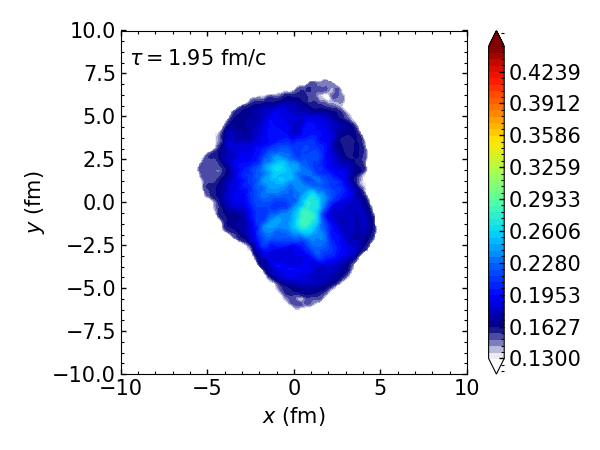

In [10]:
X, Y = meshgrid(x, y)
data_tauframe = get_medium_at_tau(0, data)

# first plot the first frame as a contour plot
fig = plt.figure()
cont = plt.contourf(X, Y, data_tauframe[1][0, :, :].transpose(), levels,
                    cmap=my_cmap, extend='both')
time_text = plt.text(-9.5, 8, r"$\tau = {0:4.2f}$ fm/c".format(tau_list[0]))
cbar = fig.colorbar(cont)
plt.xlabel(r"$x$ (fm)")
plt.ylabel(r"$y$ (fm)")
plt.xlim([-10, 10])
plt.ylim([-10, 10])
plt.tight_layout()

# define animation function to update the contour at every time frame
def animate(i): 
    global cont, time_text
    for c in cont.collections:
        c.remove()  # removes only the contours, leaves the rest intact
    data_tauframe = get_medium_at_tau(i, data)
    cont = plt.contourf(X, Y, data_tauframe[1][0, :, :].transpose(),
                        levels, cmap=my_cmap, extend='both')
    time_text.set_text(r"$\tau = {0:4.2f}$ fm/c".format(tau_list[i]))
    return cont, time_text

# create the animation
anim = animation.FuncAnimation(fig, animate, frames=ntau, repeat=False)

# save the animation to a file
# anim.save('RunTempDepVisc_animation_T.mp4', fps=15)

<IPython.core.display.Javascript object>


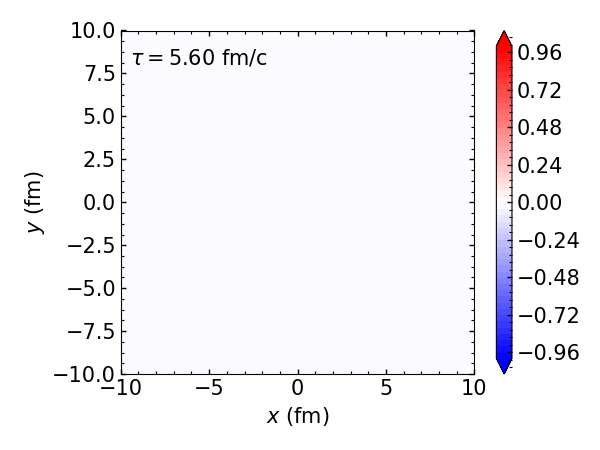

In [10]:
X, Y = meshgrid(x, y)
data_tauframe = get_medium_at_tau(0, data)

levels2 = linspace(-1., 1., 51)
# first plot the first frame as a contour plot
fig = plt.figure()
cont = plt.contourf(X, Y, data_tauframe[-1][0, :, :].transpose(), levels2,
                    cmap='bwr', extend='both')
time_text = plt.text(-9.5, 8, r"$\tau = {0:4.2f}$ fm/c".format(tau_list[0]))
cbar = fig.colorbar(cont)
plt.xlabel(r"$x$ (fm)")
plt.ylabel(r"$y$ (fm)")
plt.xlim([-10, 10])
plt.ylim([-10, 10])
plt.tight_layout()

# define animation function to update the contour at every time frame
def animate(i): 
    global cont, time_text
    for c in cont.collections:
        c.remove()  # removes only the contours, leaves the rest intact
    data_tauframe = get_medium_at_tau(i, data)
    cont = plt.contourf(X, Y, data_tauframe[-1][0, :, :].transpose(),
                        levels2, cmap='bwr', extend='both')
    time_text.set_text(r"$\tau = {0:4.2f}$ fm/c".format(tau_list[i]))
    return cont, time_text

# create the animation
anim = animation.FuncAnimation(fig, animate, frames=ntau, repeat=False)

# save the animation to a file
# anim.save('RunTempDepVisc_animation_T.mp4', fps=15)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: ComplexWarning: Casting complex values to real discards the imaginary part
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: ComplexWarning: Casting complex values to real discards the imaginary part


<IPython.core.display.Javascript object>


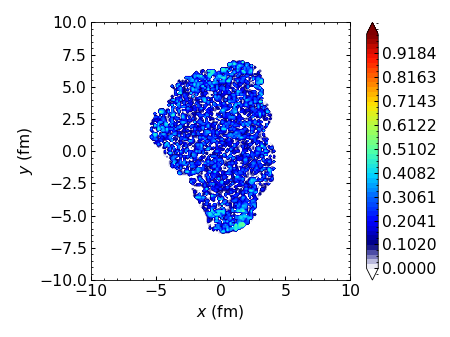

In [87]:
# make a 2D meshgrid in the transverse plane
X, Y = meshgrid(x, y)

data_tauframe = get_medium_at_tau(0, data)
Lambda = get_eigenvalue(data_tauframe[4],data_tauframe[5],data_tauframe[6],data_tauframe[7],data_tauframe[8])
#print(abs(Lambda[0]+Lambda[1]+Lambda[2]).max())

# make the contour plot
fig = plt.figure()
cont = plt.contourf(X, Y, Lambda[1][0, :, :].transpose(),
                    levels = linspace(0., 1., 50), cmap=my_cmap, extend='both')
cbar = fig.colorbar(cont)
plt.xlabel(r"$x$ (fm)")
plt.ylabel(r"$y$ (fm)")
plt.xlim([-10, 10])
plt.ylim([-10, 10])
plt.tight_layout()
plt.savefig("RunTempDepVisc_Temperature_Contour_XY")

<IPython.core.display.Javascript object>


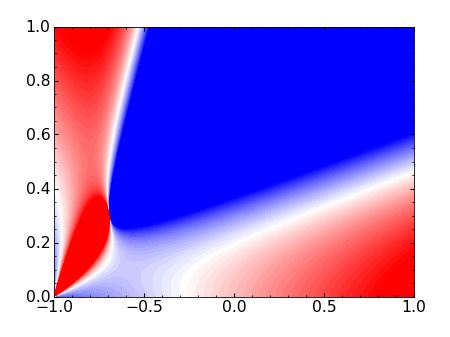

In [127]:
cs2=0.2
#0.1,0.2,0.3

r_max = np.linspace(0., 1. ,1000)
r_Pi = np.linspace(-1., 1. ,1000)
r_Pi, r_max = np.meshgrid(r_Pi, r_max)

s1 = 1./5.*r_Pi - 6./7.*r_max + 2./5.

s2 = 3.*r_Pi - 25./7.*r_max + 1 

s3 = (22./15.*r_Pi + (117. - 21.*cs2)/35.*r_max + 291./20.*(1./3. - cs2)**2
      + 4./15. + (34./7.*(29./70. - 3./5.*cs2)*r_max**2.)/(2./5.*r_Pi - 12./7.*r_max + 4./5.)
      - (1. + r_Pi)*(1. - cs2))

s4 = ((13./15. + cs2)*r_Pi - (59./105. + 13./5.*cs2)*r_max
      + 291./20.*(1./3. - cs2)**2. + (cs2 + 1./15.))

s5 = (5./3.*r_Pi - 5./7.*r_max + 1./5.)**2. - (34./7.*(29./70. - 3./5.*cs2)*r_max**2.)

s6 = ((22./15. + cs2)*r_Pi + (134./105. + 13./5.*cs2)*r_max + 291./20.*(1./3. - cs2)**2.
      + (cs2 + 4./15.) - 1./3.*(((1. + r_Pi + r_max)/(1. + r_Pi - r_max + 1e-15))**2.)
                         *(11./5.*r_Pi + 3./7.*r_max +7./5.))

index = (s1 >= 0) & (s2 > 0) & (s3 <= 0) & (s4 >= 0) & (s5 >= 0) & (s6 >= 0)

s = np.zeros([1000,1000])
s[index] = 1

levels = linspace(-1, 1, 50)

fig = plt.figure()
ax = plt.axes([0.12, 0.12, 0.8, 0.8])
#plt.title('Causality Constraints')
plt.contourf(r_Pi, r_max, z6, levels, cmap='bwr', extend='both')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: ComplexWarning: Casting complex values to real discards the imaginary part
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: ComplexWarning: Casting complex values to real discards the imaginary part


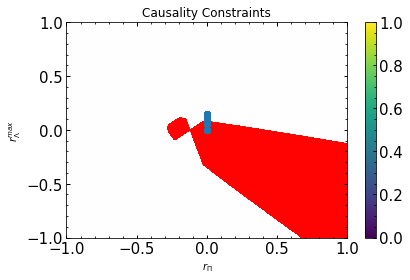

In [16]:
#sufficient conditions(too strong)
cs2=0.2  #0.1,0.2,0.3
r_max = np.linspace(-1,1,1000)
r_Pi = np.linspace(-1,1,1000)
r_Pi,r_max = np.meshgrid(r_Pi,r_max)  #generate 10 by 10 matrix
levels = np.linspace(-1,1,100)

s1 = 1/5*r_Pi-6/7*r_max+2/5

s2 = 3*r_Pi-25/7*r_max+1

s3 = 22/15*r_Pi+(117-21*cs2)/35*r_max+291/20*(1/3-cs2)**2+4/15+(34/7*(29/70-3/5*cs2)*r_max**2)/(2/5*r_Pi-12/7*r_max+4/5)-(1+r_Pi)*(1-cs2)

s4 = (13/15+cs2)*r_Pi-(59/105+13/5*cs2)*r_max+291/20*(1/3-cs2)**2+(cs2+1/15)

s5 = (5/3*r_Pi-5/7*r_max+1/5)**2-(34/7*(29/70-3/5*cs2)*r_max**2)

s6 = (22/15+cs2)*r_Pi+(134/105+13/5*cs2)*r_max+291/20*(1/3-cs2)**2+(cs2+4/15)-1/3*(((1+r_Pi+r_max)/(1+r_Pi-r_max))**2)*(11/5*r_Pi+3/7*r_max+7/5)

sindex = (s1>=0)&(s2>0)&(s3<=0)&(s4>=0)&(s5>=0)&(s6>=0)

s = np.zeros([1000,1000])
s[sindex] = 1

data_tauframe = get_medium_at_tau(200, data)
BulkPi = np.ravel(data_tauframe[9])
Lambdas = get_eigenvalue(data_tauframe[4],data_tauframe[5],data_tauframe[6]
                                         ,data_tauframe[7],data_tauframe[8])
Lambda1 = np.ravel(Lambdas[0])
Lambda2 = np.ravel(Lambdas[1])
Lambda3 = np.ravel(Lambdas[2])
r_pi = np.sqrt(abs(Lambda1)+abs(Lambda2)+abs(Lambda3))
r_Max = r_pi/np.sqrt(2)

plt.figure()
plt.title('Sufficient Causality Constraints')
plt.contourf(r_Pi,r_max,s,levels,cmap='bwr',extend='both')
plt.scatter(BulkPi, r_Max)
plt.colorbar()

plt.xlabel('$r_\Pi$')
plt.ylabel('$r^{max}_\Lambda$')
plt.tight_layout()
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: ComplexWarning: Casting complex values to real discards the imaginary part
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: ComplexWarning: Casting complex values to real discards the imaginary part


<IPython.core.display.Javascript object>


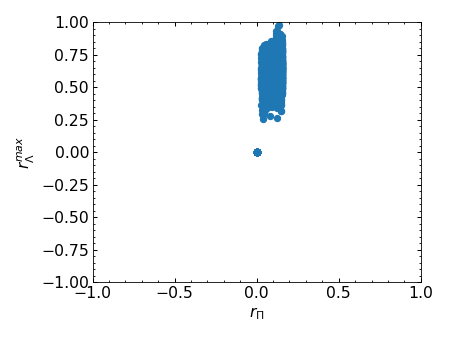

In [109]:
#data points
data_tauframe = get_medium_at_tau(0, data)
BulkPi = np.ravel(data_tauframe[9])
Lambdas = get_eigenvalue(data_tauframe[4],data_tauframe[5],data_tauframe[6]
                                         ,data_tauframe[7],data_tauframe[8])
Lambda1 = np.ravel(Lambdas[0])
Lambda2 = np.ravel(Lambdas[1])
Lambda3 = np.ravel(Lambdas[2])
for i in range(len(Lambda1)):
    r_pi[i] = np.sqrt(abs(Lambda1[i])+abs(Lambda2[i])+abs(Lambda3[i]))
r_pi = np.sqrt(abs(Lambda1)+abs(Lambda2)+abs(Lambda3))
r_Max = np.zeros(r_pi.shape)
r_Max[:] = [x/np.sqrt(2) for x in r_pi]
plt.figure()
plt.scatter(BulkPi, r_Max)
plt.xlim(-1,1)
plt.ylim(-1,1)
plt.xlabel('$r_\Pi$')
plt.ylabel('$r^{max}_\Lambda$')
plt.tight_layout()
plt.show()

<ipython-input-28-a07379530994>:45: ComplexWarning: Casting complex values to real discards the imaginary part
  Lambda_1[i,j,k] = float(w[0])
<ipython-input-28-a07379530994>:46: ComplexWarning: Casting complex values to real discards the imaginary part
  Lambda_2[i,j,k] = float(w[1])
<ipython-input-28-a07379530994>:47: ComplexWarning: Casting complex values to real discards the imaginary part
  Lambda_3[i,j,k] = float(w[2])


0.0


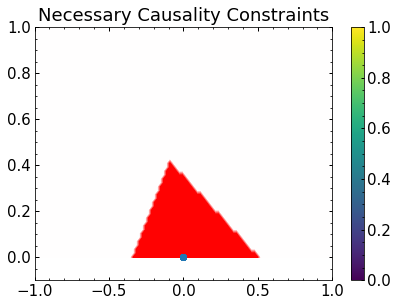

In [75]:
#necessary conditions
cs2=1./3.   #0.1,0.2,0.3
L1 = np.linspace(-1., 0., 50)
L3 = np.linspace(0., 1., 60)
Pi = np.linspace(-1., 1., 100)
Pi, L1, L3 = np.meshgrid(Pi, L1, L3)
L2 = -L1 - L3

C_eta = 5.
zeta_r = 291./20.*(1./3.-cs2)**2
taupipi_pi = 10./7.
deltapipi_pi = 4./3.
lambdapiPi_pi = 6./5.
deltaPiPi_Pi = 2./3.
lambdaPipi_Pi = 8./5.*(1./3.-cs2)

n1 = 2./C_eta + lambdapiPi_pi*Pi - 1./2.*taupipi_pi*abs(L1)

n2 = 1. - 1./C_eta + (1. - 1./2.*lambdapiPi_pi)*Pi - 1./4.*taupipi_pi*L3

#n3_1 = 1./C_eta+1./2.*lambdapiPi_pi*Pi+1./4.*taupipi_pi*(-L1)
#n3_2 = 1./C_eta+1./2.*lambdapiPi_pi*Pi+1./4.*taupipi_pi*(L1+L3)
n3_3 = 1./C_eta + 1./2.*lambdapiPi_pi*Pi - 1./4.*taupipi_pi*L3

n4_1 = 1. - 1./C_eta + (1. - lambdapiPi_pi/2.)*Pi + (1. - taupipi_pi/4.)*L1 - taupipi_pi/4.*L2
n4_2 = 1. - 1./C_eta + (1. - lambdapiPi_pi/2.)*Pi + (1. - taupipi_pi/4.)*L1 - taupipi_pi/4.*L3
n4_3 = 1. - 1./C_eta + (1. - lambdapiPi_pi/2.)*Pi + (1. - taupipi_pi/4.)*L2 - taupipi_pi/4.*L1
n4_4 = 1. - 1./C_eta + (1. - lambdapiPi_pi/2.)*Pi + (1. - taupipi_pi/4.)*L2 - taupipi_pi/4.*L3
n4_5 = 1. - 1./C_eta + (1. - lambdapiPi_pi/2.)*Pi + (1. - taupipi_pi/4.)*L3 - taupipi_pi/4.*L1
n4_6 = 1. - 1./C_eta + (1. - lambdapiPi_pi/2.)*Pi + (1. - taupipi_pi/4.)*L3 - taupipi_pi/4.*L2

n5_1 = (cs2 + 4./3.*1./C_eta + zeta_r + (2./3.*lambdapiPi_pi + deltaPiPi_Pi + cs2)*Pi
        + (deltapipi_pi + 1./3.*taupipi_pi + lambdaPipi_Pi + cs2)*L1)
#n5_2 = cs2+4./3.*1./C_eta+zeta_r+(2./3.*lambdapiPi_pi+deltaPiPi_Pi+cs2)*Pi+(deltapipi_pi+1./3.*taupipi_pi+lambdaPipi_Pi+cs2)*(-L1-L3)
#n5_3 = cs2+4./3.*1./C_eta+zeta_r+(2./3.*lambdapiPi_pi+deltaPiPi_Pi+cs2)*Pi+(deltapipi_pi+1./3.*taupipi_pi+lambdaPipi_Pi+cs2)*L3

#n6_1 = 1-cs2-4./3.*1./C_eta-zeta_r+(1.-2./3.*lambdapiPi_pi-deltaPiPi_Pi-cs2)*Pi+(1.-deltapipi_pi-1./3.*taupipi_pi-lambdaPipi_Pi-cs2)*L1
#n6_2 = 1-cs2-4./3.*1./C_eta-zeta_r+(1.-2./3.*lambdapiPi_pi-deltaPiPi_Pi-cs2)*Pi+(1.-deltapipi_pi-1./3.*taupipi_pi-lambdaPipi_Pi-cs2)*(-L1-L3)
n6_3 = (1. - cs2 - 4./3.*1./C_eta - zeta_r + (1. - 2./3.*lambdapiPi_pi - deltaPiPi_Pi - cs2)*Pi
        + (1. - deltapipi_pi - 1./3.*taupipi_pi - lambdaPipi_Pi - cs2)*L3)

#nindex = (n1>=0) & (n2>=0) & (n3_1>=0)&(n3_2>=0)&(n3_3>=0)&(n4_1>=0)&(n4_2>=0)&(n4_3>=0)&(n4_4>=0)&(n4_5>=0)&(n4_6>=0)&(n5_1>=0)&(n5_2>=0)&(n5_3>=0)&(n6_1>=0)&(n6_2>=0)&(n6_3>=0)
nindex = ((n1 >= 0) & (n2 >= 0) & (n3_3 >= 0)
          & (n4_1 >= 0) & (n4_2 >= 0) & (n4_3 >= 0) & (n4_4 >= 0) & (n4_5 >= 0) & (n4_6 >= 0)
          & (n5_1 >= 0) & (n6_3 >= 0))

n = np.zeros(Pi.shape)
n[nindex] = 1

data_tauframe = get_medium_at_tau(20, data)
BulkPi = np.ravel(data_tauframe[10])
Lambdas = get_eigenvalue(data_tauframe[5],data_tauframe[6],data_tauframe[7]
                                         ,data_tauframe[8],data_tauframe[9])
Lambda1 = np.ravel(Lambdas[0])
Lambda2 = np.ravel(Lambdas[1])
Lambda3 = np.ravel(Lambdas[2])
r_pi = np.sqrt(abs(Lambda1) + abs(Lambda2) +abs(Lambda3))
r_Max = r_pi/np.sqrt(2)

L1_idx = 49
print(L1[L1_idx, 0, 0])
idx = abs(Lambda1 - L1[L1_idx, 0, 0]) < 1e-3

plt.figure()
#ax = plt.axes(projection='3d')
#ax.contour3D(Pi, L1, L3, n, cmap='binary')
levels = np.linspace(-1,1,100)
plt.contourf(Pi[L1_idx,:,:], L3[L1_idx,:,:],n[L1_idx,:,:],levels,cmap='bwr',extend='both')
plt.title('Necessary Causality Constraints')
plt.scatter(BulkPi[idx], Lambda3[idx])
plt.ylim([-0.1, 1.0])
plt.colorbar()
plt.tight_layout()
plt.show()


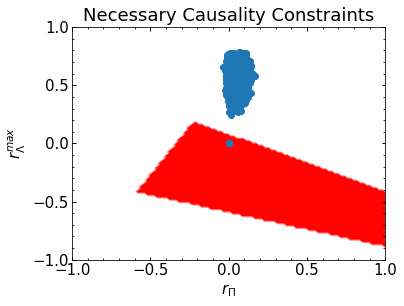

In [66]:
#necessary conditions with r_max implemented
cs2=0.15   #0.1,0.2,0.3
r_max = np.linspace(-1,1,100)
Pi = np.linspace(-1,1,100)
Pi,r_max = np.meshgrid(Pi,r_max)
C_eta = 5.
zeta_r = 291./20.*(1./3.-cs2)**2
taupipi_pi = 10./7.
deltapipi_pi = 4./3.
lambdapiPi_pi = 6./5.
deltaPiPi_Pi = 2./3.
lambdaPipi_Pi = 8./5.*(1./3.-cs2)

n1 = 2./C_eta+lambdapiPi_pi*Pi-1./2.*taupipi_pi*r_max

n2 = 1.-1./C_eta+(1.-1./2.*lambdapiPi_pi)*Pi-1./4.*taupipi_pi*r_max

n3 = 1./C_eta+1./2.*lambdapiPi_pi*Pi-1./4.*taupipi_pi*r_max

n4_1 = 1.-1./C_eta+(1.-1./2.*lambdapiPi_pi)*Pi-r_max+1./4.*taupipi_pi*r_max
n4_2 = 1.-1./C_eta+(1.-1./2.*lambdapiPi_pi)*Pi+r_max+1./4.*taupipi_pi*r_max
n4_3 = 1.-1./C_eta+(1.-1./2.*lambdapiPi_pi)*Pi+r_max-1./4.*taupipi_pi*r_max

n5 = cs2+4./3.*1./C_eta+zeta_r+(2./3.*lambdapiPi_pi+deltaPiPi_Pi+cs2)*Pi-(deltapipi_pi+1./3.*taupipi_pi+lambdaPipi_Pi+cs2)*r_max

n6 = 1-cs2-4./3.*1./C_eta-zeta_r+(1.-2./3.*lambdapiPi_pi-deltaPiPi_Pi-cs2)*Pi+(1.-deltapipi_pi-1./3.*taupipi_pi-lambdaPipi_Pi-cs2)*r_max

nindex = (n1>=0)&(n2>=0)&(n3>=0)&(n4_1>=0)&(n4_2>=0)&(n4_3>=0)&(n5>=0)&(n6>=0)
n = np.zeros([100,100])
n[nindex] = 1

plt.figure()
plt.title('Necessary Causality Constraints')
plt.contourf(Pi,r_max,n,levels,cmap='bwr',extend='both')
plt.scatter(BulkPi, r_Max)

plt.xlabel('$r_\Pi$')
plt.ylabel('$r^{max}_\Lambda$')
plt.tight_layout()
plt.show()




[0.13605442 0.14285714 0.14965986 0.15646259 0.16326531 0.17006803
 0.17687075 0.18367347 0.19047619 0.19727891 0.20408163 0.21088435
 0.21768707 0.2244898  0.23129252 0.23809524 0.24489796 0.25170068
 0.2585034  0.26530612 0.27210884 0.27891156 0.28571429 0.29251701
 0.29931973 0.30612245 0.31292517 0.31972789 0.32653061 0.33333333]


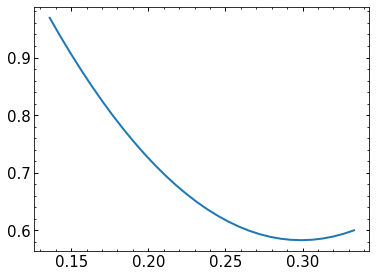

In [73]:
cs2 = linspace(0.0, 1./3., 50)
yy = cs2 + 4./15. + 14.55*(1./3. - cs2)**2.
idx = yy < 1
print(cs2[idx])
plt.figure()
plt.plot(cs2[idx], yy[idx])

In [18]:
#Pi,L1,L2,L3
x = np.linspace(-1,1,10)
#cs2
y = np.linspace(0.15,1./3.,10)

W,X,Y,Z, = np.meshgrid(x,x,x,y)
Pi = np.ravel(W)
cs2 = np.ravel(Z)
A = - X - Y
L3 = np.ravel(np.maximum.reduce([A,X,Y]))
L1 = np.ravel(np.minimum.reduce([A,X,Y]))
L2 = - L3 - L1



In [19]:
#necessary conditions
#Pi = data[:, 16]
#cs2 = data[:, 7]
#Lambdas = get_eigenvalue_list(data[:, 11], data[:, 12], data[:, 13],
#                              data[:, 14], data[:, 15])
#L1 = Lambdas[0]
#L2 = Lambdas[1]
#L3 = Lambdas[2]

C_eta = 5.
zeta_r = (1./3.-cs2)/(2.-np.log(2))
#zeta_r = 291./20.*(1./3.-cs2)**2
#the choice of zeta_r is important
taupipi_pi = 10./7.*0
deltapipi_pi = 4./3.
lambdapiPi_pi = 6./5.*0
deltaPiPi_Pi = 2./3.*0
lambdaPipi_Pi = 8./5.*(1./3.-cs2)*0

n1 = 2./C_eta + lambdapiPi_pi*Pi - 1./2.*taupipi_pi*abs(L1)

n2 = 1. - 1./C_eta + (1. - 1./2.*lambdapiPi_pi)*Pi - 1./4.*taupipi_pi*L3

#n3_1 = 1./C_eta+1./2.*lambdapiPi_pi*Pi+1./4.*taupipi_pi*(-L1)
#n3_2 = 1./C_eta+1./2.*lambdapiPi_pi*Pi+1./4.*taupipi_pi*(L1+L3)
n3_3 = 1./C_eta + 1./2.*lambdapiPi_pi*Pi - 1./4.*taupipi_pi*L3

n4_1 = 1. - 1./C_eta + (1. - lambdapiPi_pi/2.)*Pi + (1. - taupipi_pi/4.)*L1 - taupipi_pi/4.*L2
n4_2 = 1. - 1./C_eta + (1. - lambdapiPi_pi/2.)*Pi + (1. - taupipi_pi/4.)*L1 - taupipi_pi/4.*L3
n4_3 = 1. - 1./C_eta + (1. - lambdapiPi_pi/2.)*Pi + (1. - taupipi_pi/4.)*L2 - taupipi_pi/4.*L1
n4_4 = 1. - 1./C_eta + (1. - lambdapiPi_pi/2.)*Pi + (1. - taupipi_pi/4.)*L2 - taupipi_pi/4.*L3
n4_5 = 1. - 1./C_eta + (1. - lambdapiPi_pi/2.)*Pi + (1. - taupipi_pi/4.)*L3 - taupipi_pi/4.*L1
n4_6 = 1. - 1./C_eta + (1. - lambdapiPi_pi/2.)*Pi + (1. - taupipi_pi/4.)*L3 - taupipi_pi/4.*L2

n5_1 = (cs2 + 4./3.*1./C_eta + zeta_r + (2./3.*lambdapiPi_pi + deltaPiPi_Pi + cs2)*Pi
        + (deltapipi_pi + 1./3.*taupipi_pi + lambdaPipi_Pi + cs2)*L1)
#n5_2 = cs2+4./3.*1./C_eta+zeta_r+(2./3.*lambdapiPi_pi+deltaPiPi_Pi+cs2)*Pi+(deltapipi_pi+1./3.*taupipi_pi+lambdaPipi_Pi+cs2)*(-L1-L3)
#n5_3 = cs2+4./3.*1./C_eta+zeta_r+(2./3.*lambdapiPi_pi+deltaPiPi_Pi+cs2)*Pi+(deltapipi_pi+1./3.*taupipi_pi+lambdaPipi_Pi+cs2)*L3

#n6_1 = 1-cs2-4./3.*1./C_eta-zeta_r+(1.-2./3.*lambdapiPi_pi-deltaPiPi_Pi-cs2)*Pi+(1.-deltapipi_pi-1./3.*taupipi_pi-lambdaPipi_Pi-cs2)*L1
#n6_2 = 1-cs2-4./3.*1./C_eta-zeta_r+(1.-2./3.*lambdapiPi_pi-deltaPiPi_Pi-cs2)*Pi+(1.-deltapipi_pi-1./3.*taupipi_pi-lambdaPipi_Pi-cs2)*(-L1-L3)
n6_3 = (1. - cs2 - 4./3.*1./C_eta - zeta_r + (1. - 2./3.*lambdapiPi_pi - deltaPiPi_Pi - cs2)*Pi
        + (1. - deltapipi_pi - 1./3.*taupipi_pi - lambdaPipi_Pi - cs2)*L3)

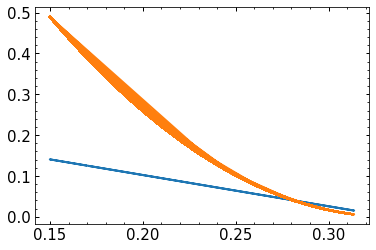

In [23]:
plt.figure()
plt.plot(cs2,(1./3.-cs2)/(2.-np.log(2)))
plt.plot(cs2,291./20.*(1./3.-cs2)**2)

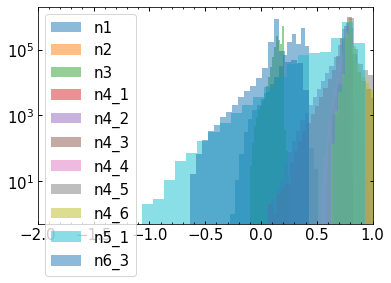

In [20]:
alpha_value = 0.5
plt.figure()
plt.hist(n1, 20, alpha = alpha_value, label='n1')
plt.hist(n2, 20, alpha = alpha_value, label='n2')
plt.hist(n3_3, 20, alpha = alpha_value, label='n3')
plt.hist(n4_1, 20, alpha = alpha_value, label='n4_1')
plt.hist(n4_2, 20, alpha = alpha_value, label='n4_2')
plt.hist(n4_3, 20, alpha = alpha_value, label='n4_3')
plt.hist(n4_4, 20, alpha = alpha_value, label='n4_4')
plt.hist(n4_5, 20, alpha = alpha_value, label='n4_5')
plt.hist(n4_6, 20, alpha = alpha_value, label='n4_6')
plt.hist(n5_1, 20, alpha = alpha_value, label='n5_1')
plt.hist(n6_3, 20, alpha = alpha_value, label='n6_3')
plt.xlim([-2, 1])
plt.yscale('log')
plt.legend(loc=0);

(-1.0, 1.0)

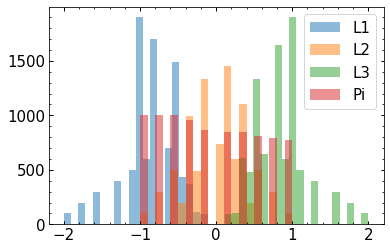

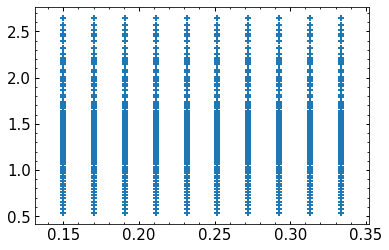

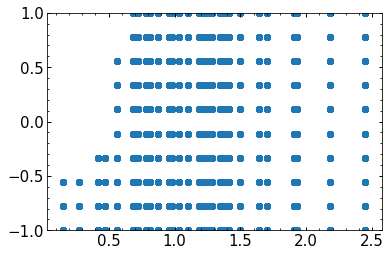

In [27]:
idx = ((n1 < 0) | (n2 < 0) |(n3_3 < 0) | (n4_1 < 0) | (n4_2 < 0) | (n4_3 < 0) | (n5_1 < 0) | (n6_3 < 0)) 

alpha_value = 0.5
plt.figure()
plt.hist(L1[idx], 20, alpha = alpha_value, label='L1');
plt.hist(L2[idx], 20, alpha = alpha_value, label='L2');
plt.hist(L3[idx], 20, alpha = alpha_value, label='L3');
plt.hist(Pi[idx], 20, alpha = alpha_value, label='Pi');
plt.legend(loc=0);
plt.figure()

plt.scatter(cs2[idx], sqrt(L1[idx]**2. + L2[idx]**2. + L3[idx]**2. + Pi[idx]**2.), marker="+")
plt.figure()
plt.scatter(sqrt(L1[idx]**2. + L2[idx]**2. + L3[idx]**2.),Pi[idx])
#plt.scatter(1 - cs2[idx] - zeta_r[idx]*(1./(1. + Pi[idx])), sqrt(L1[idx]**2. + L2[idx]**2. + L3[idx]**2.), marker="+")

plt.ylim([-1., 1.])

#plt.figure()
#plt.hist(data[idx, 0], 20, alpha = alpha_value, label='time')
#plt.legend();

In [9]:
### sufficient conditions
Pi = data[:, 16]
cs2 = data[:, 7]
Lambdas = get_eigenvalue_list(data[:, 11], data[:, 12], data[:, 13],
                              data[:, 14], data[:, 15])
L1 = Lambdas[0]
L2 = Lambdas[1]
L3 = Lambdas[2]

C_eta = 5.
zeta_r = (1./3.-cs2)/(2.-np.log(2))
#zeta_r = 291./20.*(1./3.-cs2)**2
#the choice of zeta_r is important
taupipi_pi = 10./7.*0
deltapipi_pi = 4./3.
lambdapiPi_pi = 6./5.*0
deltaPiPi_Pi = 2./3.*0
lambdaPipi_Pi = 8./5.*(1./3.-cs2)*0

s1 = 1. - 1./C_eta - abs(L1) + (1. - 1./2.*lambdapiPi_pi)*Pi - (1./2.*taupipi_pi)*L3

s2 = 2./C_eta + lambdapiPi_pi*Pi - taupipi_pi*abs(L1)

s3 = ((1. + Pi)*(1. - cs2))-(4./3.*1./C_eta + zeta_r + (2./3.*lambdapiPi_pi + deltaPiPi_Pi)*Pi 
                             + (deltapipi_pi + 1./3.*taupipi_pi + lambdaPipi_Pi + cs2)*L3 + abs(L1) + 
                             ((deltapipi_pi - 1./12.*taupipi_pi)*(lambdaPipi_Pi + cs2 - 1./12.*taupipi_pi)
                              *(L3 + abs(L1))**2)/(1. - 1./C_eta + (1. - 1./2.*lambdapiPi_pi)*Pi - abs(L1) - 1./2.*taupipi_pi*L3))

s4 = 1./3./C_eta + (1./6.*lambdapiPi_pi + deltaPiPi_Pi + cs2)*Pi + (1./6.*taupipi_pi - deltapipi_pi + lambdaPipi_Pi - cs2)*abs(L1) + zeta_r + cs2

s5 = ((1./C_eta + 1./2.*lambdapiPi_pi*Pi - 1./2.*taupipi_pi*abs(L1))**2)-((deltapipi_pi - 1./12.*taupipi_pi)*(lambdaPipi_Pi + cs2 - 1./12.*taupipi_pi)*(L3+abs(L1))**2)

s6 = ((4./3./C_eta + (2./3.*lambdapiPi_pi + deltaPiPi_Pi + cs2)*Pi 
      - (deltapipi_pi + 1./3.*taupipi_pi - lambdaPipi_Pi + cs2)*abs(L1) + zeta_r + cs2)
    -(((1. + Pi + L2)*(1. + Pi + L3)/(3*(1. + Pi - abs(L1))**2))
      *(1. + 1./2./C_eta +(1. + lambdapiPi_pi)*Pi - abs(L1) + taupipi_pi*L3)))






/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: ComplexWarning: Casting complex values to real discards the imaginary part
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:67: ComplexWarning: Casting complex values to real discards the imaginary part
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:68: ComplexWarning: Casting complex values to real discards the imaginary part


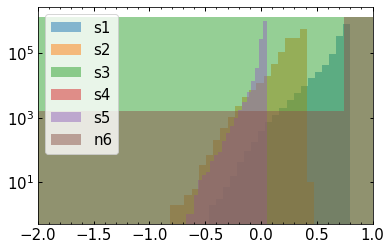

In [14]:
alpha_value = 0.5
plt.figure()
plt.hist(s1, 20, alpha = alpha_value, label='s1')
plt.hist(s2, 20, alpha = alpha_value, label='s2')
plt.hist(s3, 20, alpha = alpha_value, label='s3')
plt.hist(s4, 20, alpha = alpha_value, label='s4')
plt.hist(s5, 20, alpha = alpha_value, label='s5')
plt.hist(s6, 20, alpha = alpha_value, label='n6')

plt.xlim([-2, 1])
plt.yscale('log')
plt.legend(loc=0);

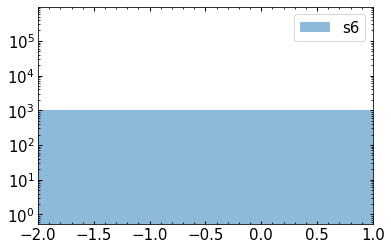

In [28]:
alpha_value = 0.5
plt.figure()
plt.hist(s6, 20, alpha = alpha_value, label='s6')
plt.xlim([-2, 1])
plt.yscale('log')
plt.legend(loc=0);

(array([52427., 53505., 56844., 61325., 65849., 70840., 76247., 81702.,
        87215., 83077., 93968., 95649., 95560., 94329., 90153., 79833.,
        54386., 26765., 11606.,  3372.]),
 array([  0. ,  10.9,  21.8,  32.7,  43.6,  54.5,  65.4,  76.3,  87.2,
         98.1, 109. , 119.9, 130.8, 141.7, 152.6, 163.5, 174.4, 185.3,
        196.2, 207.1, 218. ], dtype=float32),
 <a list of 20 Patch objects>)

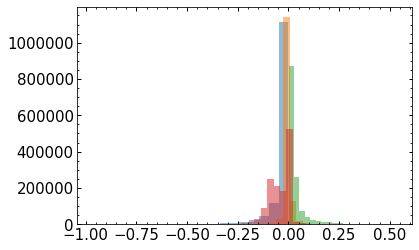

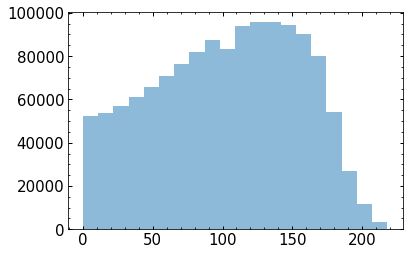

In [16]:
idx = ((s1 > 0) | (s2 > 0) | (s3 > 0) | (s4 > 0) | (s5 > 0) | (s6 > 0))

alpha_value = 0.5
plt.figure()
plt.hist(L1[idx], 20, alpha = alpha_value);
plt.hist(L2[idx], 20, alpha = alpha_value);
plt.hist(L3[idx], 20, alpha = alpha_value);
plt.hist(Pi[idx], 20, alpha = alpha_value);

plt.figure()
plt.hist(data[idx, 0], 20, alpha = alpha_value)